# Evaluate Proxima Performance
There are a few things we want to watch to see if Proxima is working as intended:
1. Is the machine learning model getting used more often?
2. Is the machine learning model getting better?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from cascade.learning.torchani import TorchANI
from pathlib import Path
from ase.io import read
from ase import units
import pickle as pkl
import pandas as pd
import numpy as np
import json

/home/lward/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


Configuration

In [2]:
run_dir = 'runs/si-vacancy-2x2x2-blyp-temp=800.0-method=blyp-93657a7f/'

In [3]:
run_dir = Path(run_dir)
params = json.loads((run_dir / 'params.json').read_text())

## Load in run data
We are going to look at the log file produced by the run script, which is line-delimited JSON records

In [85]:
data = pd.read_json(run_dir / 'proxima-log.json', lines=True)
data.tail()

,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,last_uncer,last_error
1020,0.037192,-6676.608643,2.253602,"[0.000123056583106, 0.0034882270265370005, 0.0...",650.091754,1362.181511,True,17.817115,0.306336,0.057538,3.715728
1021,0.035754,-6676.643311,2.220943,"[0.00012936955317800002, 0.0033619871828700003...",654.683728,1362.328097,True,17.817115,0.306336,0.057538,3.715728
1022,0.036600,-6676.666992,2.173155,"[0.00012091221287800001, 0.003193173324689, 0....",657.896971,1362.480860,True,17.817115,0.306336,0.057538,3.715728
1023,0.034150,-6676.678223,2.249348,"[9.608117397874595e-05, 0.0029858537018290004,...",659.571523,1362.641871,True,17.817115,0.306336,0.057538,3.715728
1024,0.037812,-6676.676025,2.384159,"[5.28140226379037e-05, 0.0027434481307860004, ...",659.588311,1362.812978,True,17.817115,0.306336,0.057538,3.715728


## Sanity Check: Plot Energy and Volume over Time
The energy and volume should not change suddenly during the run

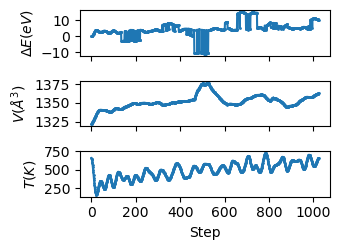

In [86]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.6), sharex=True)

ax = axs[0]
ax.plot(data.index, data['energy'] - data['energy'].iloc[0], '-o', ms=1)
ax.set_ylabel('$\\Delta E (eV)$')

ax = axs[1]
ax.plot(data.index, data['volume'], '-o', ms=1)
ax.set_ylabel('$V (\\AA^3)$')

ax = axs[2]
ax.plot(data.index, data['temperature'], '-o', ms=1)
ax.set_ylabel('$T (K)$')

ax.set_xlim(ax.get_xlim())
ax.set_xlabel('Step')

fig.tight_layout()

## Plot the model error
The `last_error` column captures the error of the surrogate model the last time the target function was used. So, it is only meaningful on timesteps where `used_surrogate` is false.

We want to see the steps at which we use the model become less frequent

In [87]:
target_ran = data.query('not used_surrogate')

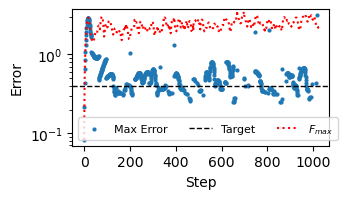

In [88]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.scatter(target_ran.index, target_ran['last_error'], s=4, label='Max Error')
ax.set_xlim(ax.get_xlim())
ax.semilogy(ax.get_xlim(), [params['target_error']]*2, 'k--', lw=1, label='Target')
ax.set_ylim(ax.get_ylim())

ax.plot(data.index, data['maximum_force'], ':r', label='$F_{max}$')

ax.set_xlabel('Step')
ax.set_ylabel('Error')
ax.legend(fontsize=8, ncols=3)

fig.tight_layout()

## Plot the Controller Performance
The proxima controller updates a threshold ($T$) and a relationship between UQ signal and system error ($\alpha$) each time the target is ran.

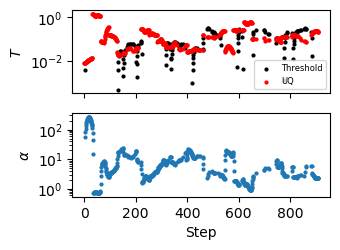

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.6), sharex=True)

ax = axs[0]
ax.scatter(target_ran.index, target_ran['proxima_threshold'], c='k', s=4, label='Threshold')
ax.scatter(target_ran.index, target_ran['last_uncer'], c='r', s=4, label='UQ')
ax.set_ylabel('$T$')
ax.set_yscale('log')
ax.legend(fontsize=6)

ax = axs[1]
ax.semilogy(target_ran.index, target_ran['proxima_alpha'], 'o', ms=2)
ax.set_ylabel('$\\alpha$')

ax.set_xlim(ax.get_xlim())
ax.set_xlabel('Step')

fig.tight_layout()

Plot the relationship between UQ signal and observed error.

There should be a positive correlation between them. The controller can work fine without a good correlation, however.

In [68]:
with open(run_dir / 'proxima-state.pkl', 'rb') as fp:
    state = pkl.load(fp)

In [69]:
uq_signal, obs_error = zip(*state['error_history'])

Text(0, 0.5, 'Actual Error')

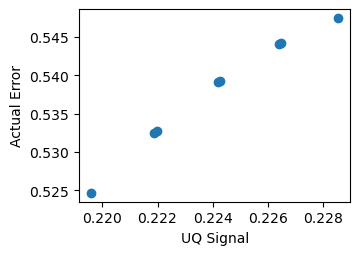

In [70]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(uq_signal, obs_error)

ax.set_xlabel('UQ Signal')
ax.set_ylabel('Actual Error')

## Plot Model Performance
See how good the model is compared to the available training data

In [71]:
models = state['models']
train_logs = state['train_logs']

KeyError: 'models'

In [72]:
atoms = read(run_dir / 'proxima.db', ':')

Run inference

In [73]:
pred_e, pred_f, pred_s = TorchANI().evaluate(models[1], atoms)

Convert energies to per atom above the minimum in meV/atom

In [74]:
pred_e_pera = np.divide(pred_e, [len(a) for a in atoms])
true_e_pera = np.divide([a.get_potential_energy() for a in atoms], [len(a) for a in atoms])

In [50]:
pred_e_pera -= true_e_pera.min()
true_e_pera -= true_e_pera.min()

In [51]:
for m in [pred_e_pera, true_e_pera]:
    m *= 1000.

In [52]:
true_f = [a.get_forces() for a in atoms]

Plot comparison

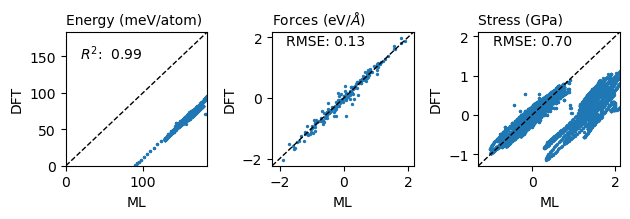

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(6.4, 2.3))

ax = axs[0]
ax.scatter(pred_e_pera, true_e_pera, s=2)
lim = [
    min(pred_e_pera.min(), true_e_pera.min()),
    max(pred_e_pera.max(), true_e_pera.max())
]
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

r2_score = np.corrcoef(pred_e_pera, true_e_pera)[0, 1]
ax.text(0.1, 0.8, f'$R^2$: {r2_score: .2f}', transform=ax.transAxes, fontsize=10)

ax.set_title('Energy (meV/atom)', loc='left', fontsize=10)

ax = axs[1]
ax.scatter(pred_f[-1].flatten(), true_f[-1].flatten(), s=2)
ax.set_title('Forces (eV/$\\AA$)', loc='left', fontsize=10)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

rmse = np.sqrt(np.power(pred_f[-1] - true_f[-1], 2).mean())
ax.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=10)


ax = axs[2]
true_s = np.array([a.get_stress(False) for a in atoms])
ax.scatter(pred_s.flatten() / units.GPa, true_s.flatten() / units.GPa, s=2)
ax.set_title('Stress (GPa)', loc='left', fontsize=10)

rmse = np.sqrt(np.power(pred_s - true_s, 2).mean()) / units.GPa
ax.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=10)


ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

for ax in axs:
    ax.set_xlabel('ML')
    ax.set_ylabel('DFT')

fig.tight_layout()

Plot the training results

Text(0.5, 0, 'Epoch')

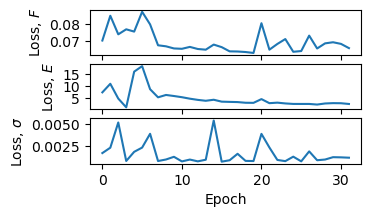

In [54]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.), sharex=True)

log = train_logs[0]
for ax, tag, letter in zip(axs, ['F', 'E', '\\sigma'], ['f', 'e', 's']):
    ax.plot(log['iteration'], log[f'{letter}_rmse_valid'])
    ax.set_ylabel(f'Loss, ${tag}$')
    
#axs[-1].set_ylabel('Loss')
axs[-1].set_xlabel('Epoch')